# Baseline Collaborative Filtering
Explore user-based and item-based CF using cosine similarity on the sparse interaction matrix.

In [1]:
import sys
from pathlib import Path

ROOT = Path().resolve().parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data.loader import load_dataset
from src.data.preprocessing import (
    enrich_movies, cap_dataset, build_interaction_matrix, temporal_train_test_split
)
from src.models.similarity import user_based_recommendations, item_based_recommendations

ds = load_dataset(ROOT / 'data' / 'raw', max_rows=200_000)
ratings = cap_dataset(ds.ratings, max_users=5000, max_movies=3000)
movies  = enrich_movies(ds.movies)
train_df, test_df = temporal_train_test_split(ratings, test_ratio=0.2)
bundle  = build_interaction_matrix(train_df)
print('Matrix:', bundle.matrix.shape)

Matrix: (1302, 3000)


In [2]:
import pandas as pd

# Pick a sample user
sample_user = int(train_df['userId'].value_counts().index[0])
print('Sample user:', sample_user)

# Movies the user already rated
seen = set(train_df[train_df['userId'] == sample_user]['movieId'].tolist())
seen_titles = movies[movies['movieId'].isin(seen)]['title'].head(5).tolist()
print('Already rated:', seen_titles)

Sample user: 28
Already rated: ['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Father of the Bride Part II (1995)', 'Heat (1995)']


In [3]:
# User-based CF recommendations
user_recs = user_based_recommendations(
    user_id=sample_user,
    matrix=bundle.matrix,
    user_to_index=bundle.user_to_index,
    movie_ids=bundle.movie_ids,
    top_n=10,
)
title_map = movies.set_index('movieId')['title'].to_dict()
print('User-CF recommendations:')
for mid, score in user_recs:
    print(f'  {title_map.get(mid, mid):<55}  score={score:.4f}')

User-CF recommendations:
  Maltese Falcon, The (a.k.a. Dangerous Female) (1931)     score=5.0000
  Persona (1966)                                           score=5.0000
  Transformers: The Movie (1986)                           score=5.0000
  Final Fantasy VII: Advent Children (2004)                score=5.0000
  Stalker (1979)                                           score=5.0000
  Sicario (2015)                                           score=5.0000
  His Girl Friday (1940)                                   score=5.0000
  Dolce Vita, La (1960)                                    score=5.0000
  Jean de Florette (1986)                                  score=5.0000
  Inside Out (2015)                                        score=5.0000


In [4]:
# Item-based CF recommendations
item_recs = item_based_recommendations(
    user_id=sample_user,
    matrix=bundle.matrix,
    user_to_index=bundle.user_to_index,
    movie_ids=bundle.movie_ids,
    top_n=10,
)
print('Item-CF recommendations:')
for mid, score in item_recs:
    print(f'  {title_map.get(mid, mid):<55}  score={score:.4f}')

Item-CF recommendations:
  Gothika (2003)                                           score=5.0000
  Beethoven (1992)                                         score=5.0000
  Cat Returns, The (Neko no ongaeshi) (2002)               score=5.0000
  Grudge, The (2004)                                       score=5.0000
  Grave of the Fireflies (Hotaru no haka) (1988)           score=5.0000
  American Wedding (American Pie 3) (2003)                 score=5.0000
  Manhattan Murder Mystery (1993)                          score=5.0000
  Girl Who Leapt Through Time, The (Toki o kakeru shôjo) (2006)  score=5.0000
  Next Karate Kid, The (1994)                              score=5.0000
  Paprika (Papurika) (2006)                                score=5.0000


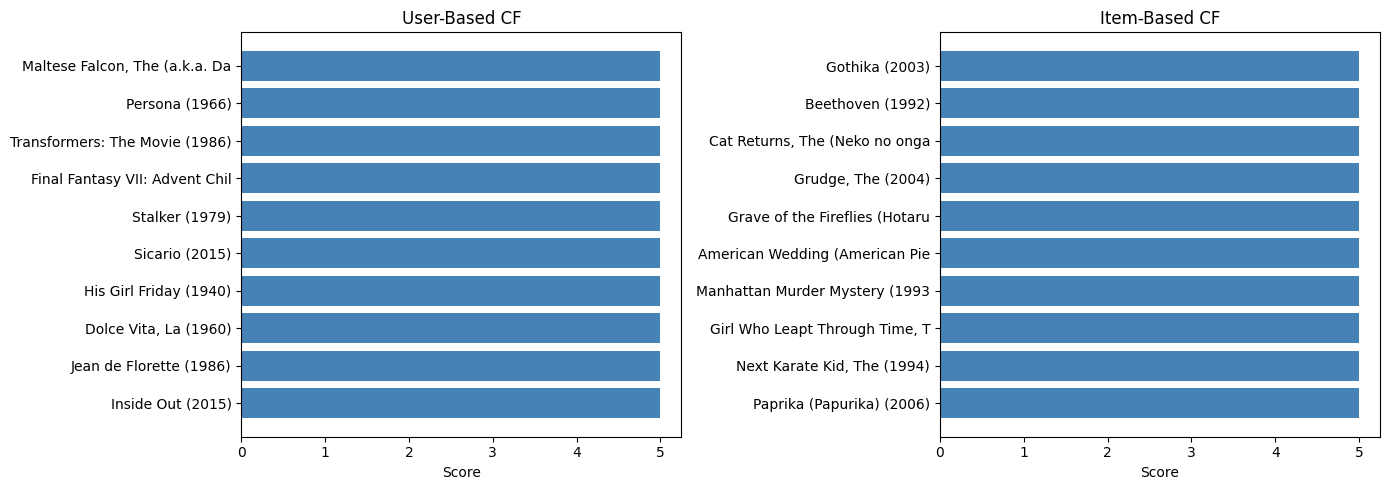

In [5]:
import matplotlib.pyplot as plt

# Compare top-10 scores side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, recs, label in [
    (axes[0], user_recs, 'User-Based CF'),
    (axes[1], item_recs, 'Item-Based CF'),
]:
    titles = [title_map.get(mid, str(mid))[:30] for mid, _ in recs]
    scores = [s for _, s in recs]
    ax.barh(titles[::-1], scores[::-1], color='steelblue')
    ax.set_title(label)
    ax.set_xlabel('Score')
plt.tight_layout()
plt.show()